# Prelim Skills Exam

| Technological Institute of the Philippines | Quezon City - Computer Engineering |
| --- | --- |
| **Course Code:** | CPE 313 |
| **Code Title:** | Advanced Machine Learning and Deep Learning |
| **2nd Semester** | AY 2023-2024 |
| --- | --- |
| **Prelim** | **Prelim Skills Exam** |
| **Name** | Mendoza, Paulo |
| --- | --- |
| **Section** | CPE32S8 |
| **Date Performed**: | March 14, 2024 |
| **Date Submitted**: | March 14, 2024 |
| **Instructor**: | Engr. Roman M. Richard |

# Instructions

Do the following using the CHEST x-rays dataset

https://www.kaggle.com/datasets/nih-chest-xrays/dataLinks to an external site.

1. Build and train a CNN model from a scratch.  Apply different regularization techniques and data preprocessing to reduce overfitting.

2.  Plot the training and validation loss and accuracy. The target accuracy is 85 and above.

3.  Use the assigned pre-trained model and fine-tuned it.

4. Build and train a CNN model using the modified pretrained model.

5. Plot the training and validation loss and accuracy. The target accuracy is 95 and above.

6. Use the classification report, confusion matrix and ROC over AUC metric to evaluate also the performance of the scratch and using pre-trained mode

# Answer

# Files in the System

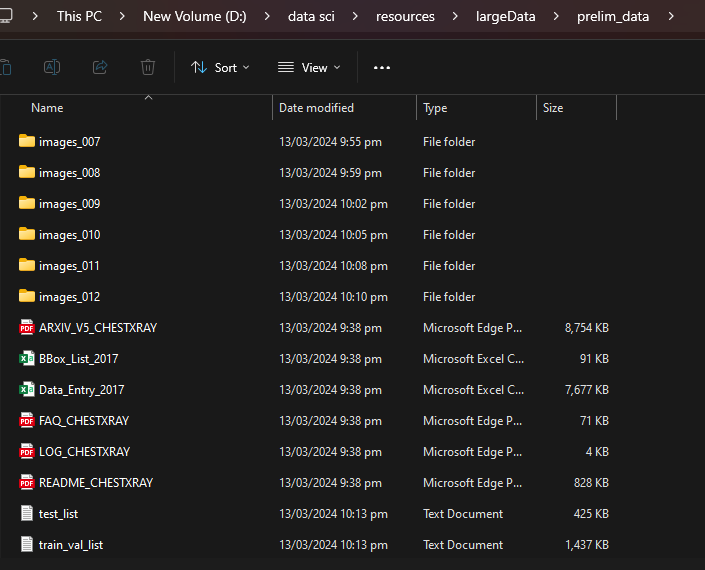

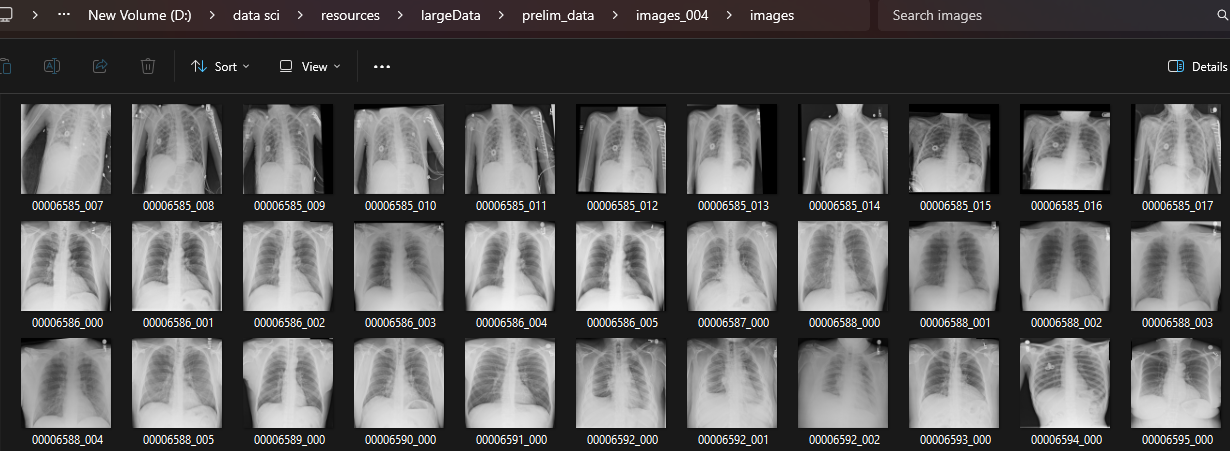

# Libraries

In [50]:
# for image manipulation and display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image
import pandas as pd 
import random

# for directory access
import os
from glob import glob

# for preperation of data
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# for model creation
from __future__ import print_function
import keras
from keras import optimizers, callbacks, regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Dense
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.applications.mobilenet import MobileNet
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# for saving model data
import json

# for tracking model execution time
import datetime

# for model's metrics
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import classification_report

# Data preparation

In [2]:
def display_image_from_array(image_array):
    """
    Display a grayscale image from a NumPy array.

    Parameters:
        image_array (numpy.ndarray): NumPy array representing the image.
    """
    plt.imshow(image_array, cmap='gray')  # Display the grayscale image
    plt.axis('off')  # Turn off axes
    plt.show()


In [3]:
all_xray_df = pd.read_csv(r'D:\data sci\resources\largeData\prelim_data/Data_Entry_2017.csv')
image_directory = r'D:\data sci\resources\largeData\prelim_data'
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join(image_directory, '**', '*.png'), recursive=True)}

print('Scans found:', len(all_image_paths), ', Total Headers:', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

all_xray_df.sample(3)

Scans found: 112120 , Total Headers: 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
95721,00025181_007.png,Nodule,7,25181,54,M,PA,2992,2991,0.143,0.143,NaN,D:\data sci\resources\largeData\prelim_data\im...
6096,00001648_003.png,No Finding,3,1648,44,M,AP,2500,2048,0.168,0.168,NaN,D:\data sci\resources\largeData\prelim_data\im...
95141,00024856_000.png,Infiltration,0,24856,68,M,PA,2674,2665,0.143,0.143,NaN,D:\data sci\resources\largeData\prelim_data\im...


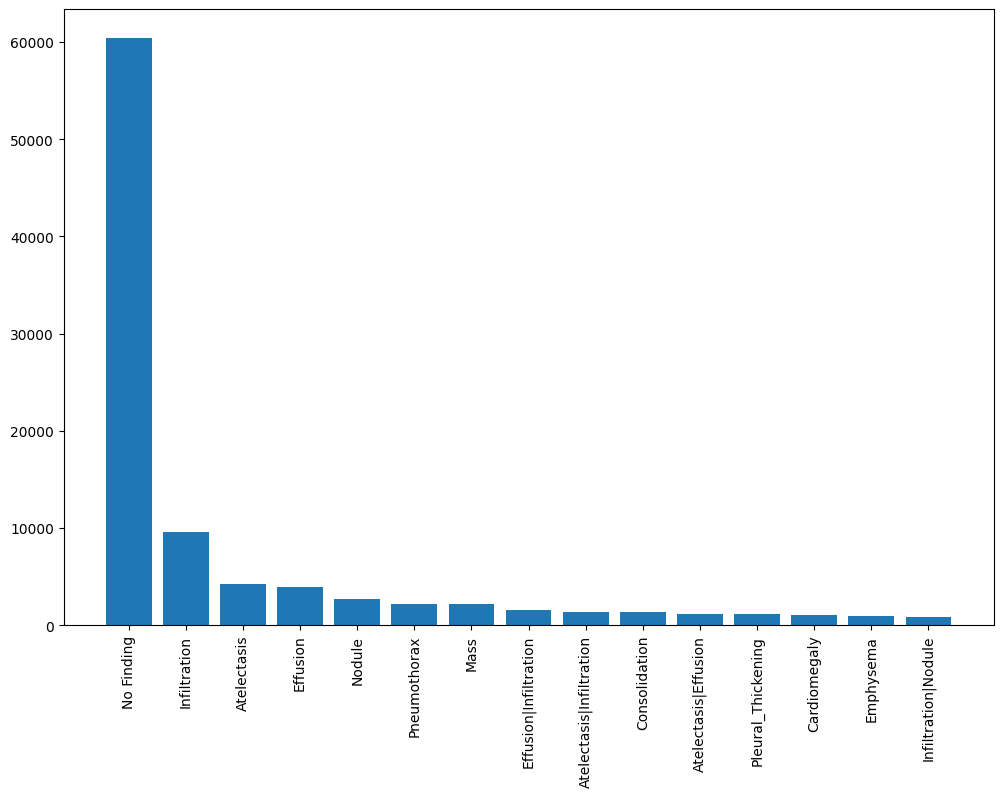

In [4]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [5]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
15155,00003981_014.png,Consolidation,14,3981,66,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66297,00016403_001.png,Nodule,1,16403,58,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12386,00003227_003.png,,3,3227,17,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [7]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


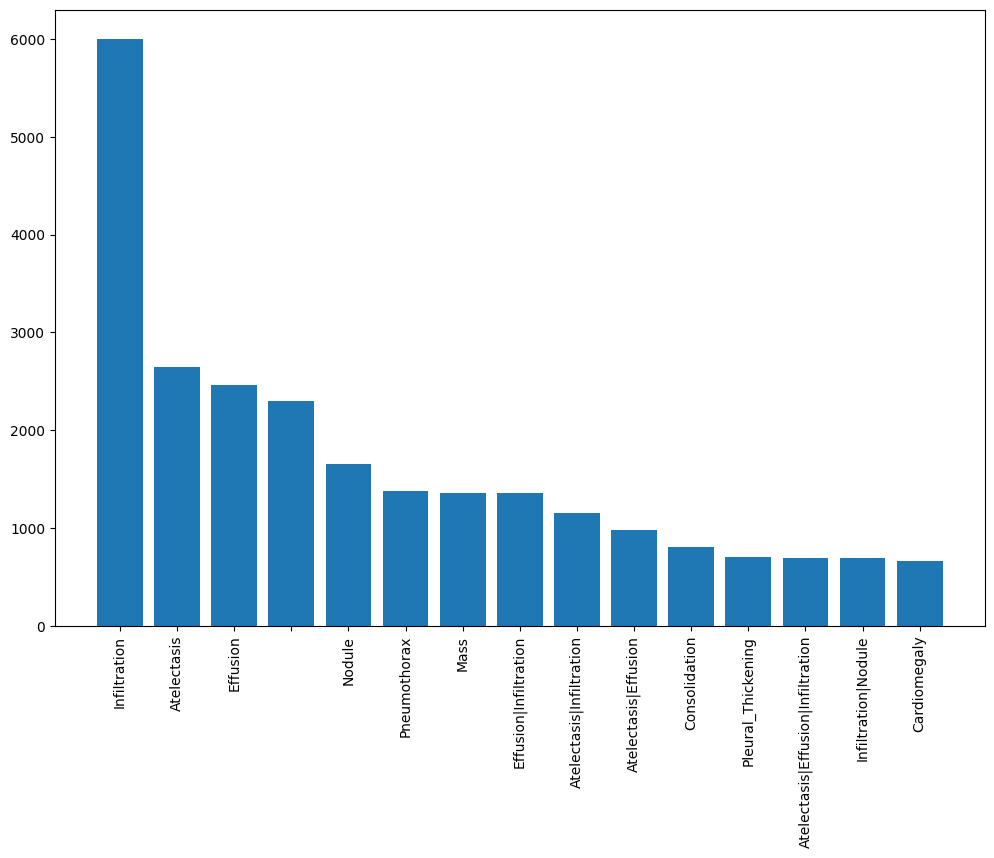

In [8]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

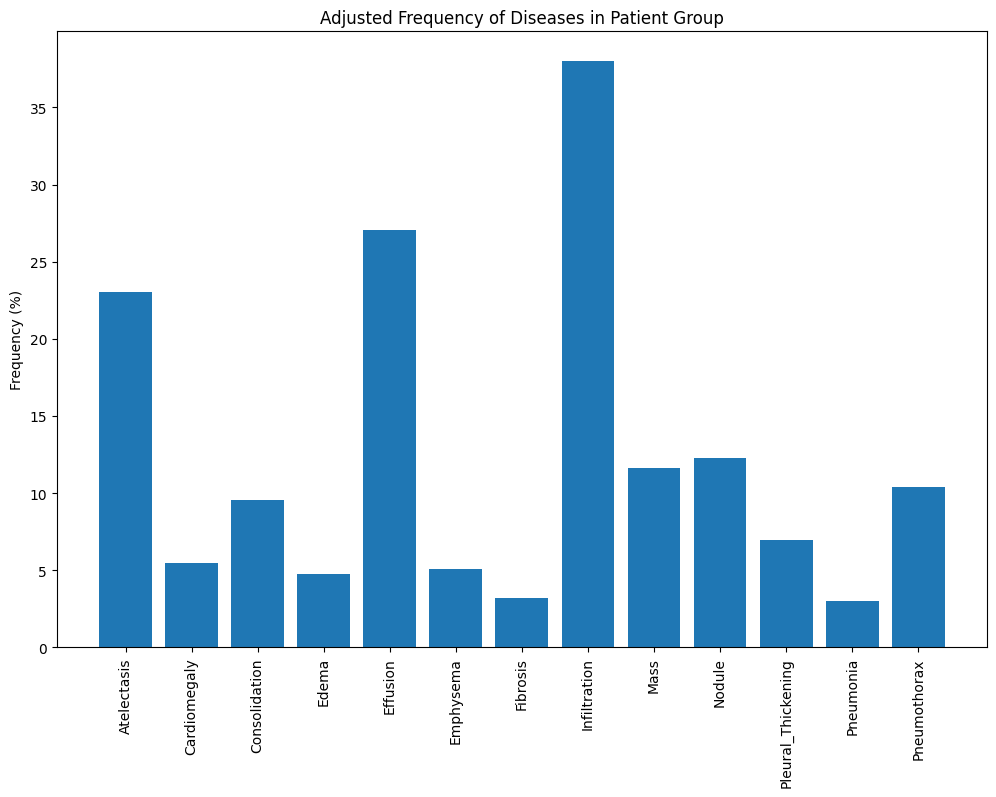

In [9]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [10]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [11]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


In [12]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

In [13]:
valid_df['newLabel'] 

98007                    [Infiltration]
26502                    [Infiltration]
106676                         [Nodule]
11697                    [Pneumothorax]
51998                     [Atelectasis]
                      ...              
19217                    [Infiltration]
40421       [Atelectasis, Infiltration]
77456                   [Consolidation]
80373       [Atelectasis, Infiltration]
103872    [Consolidation, Infiltration]
Name: newLabel, Length: 10000, dtype: object

In [14]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 98007 to 103872
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  10000 non-null  object 
 1   Finding Labels               10000 non-null  object 
 2   Follow-up #                  10000 non-null  int64  
 3   Patient ID                   10000 non-null  int64  
 4   Patient Age                  10000 non-null  int64  
 5   Patient Gender               10000 non-null  object 
 6   View Position                10000 non-null  object 
 7   OriginalImage[Width          10000 non-null  int64  
 8   Height]                      10000 non-null  int64  
 9   OriginalImagePixelSpacing[x  10000 non-null  float64
 10  y]                           10000 non-null  float64
 11  Unnamed: 11                  0 non-null      float64
 12  path                         10000 non-null  object 
 13  Atelectasis     

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 7185 to 88448
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  30000 non-null  object 
 1   Finding Labels               30000 non-null  object 
 2   Follow-up #                  30000 non-null  int64  
 3   Patient ID                   30000 non-null  int64  
 4   Patient Age                  30000 non-null  int64  
 5   Patient Gender               30000 non-null  object 
 6   View Position                30000 non-null  object 
 7   OriginalImage[Width          30000 non-null  int64  
 8   Height]                      30000 non-null  int64  
 9   OriginalImagePixelSpacing[x  30000 non-null  float64
 10  y]                           30000 non-null  float64
 11  Unnamed: 11                  0 non-null      float64
 12  path                         30000 non-null  object 
 13  Atelectasis       

In [16]:
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [17]:
train_X, train_Y = next(core_idg.flow_from_dataframe(dataframe=train_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 8000))
print("Done Train Data")
test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 2000))
print("Done Test Data")

Found 28223 validated image filenames belonging to 13 classes.
Done Train Data
Found 9405 validated image filenames belonging to 13 classes.
Done Test Data


In [18]:
train_X.shape

(8000, 128, 128, 1)

In [19]:
test_Y.shape

(2000, 13)

In [20]:
# taken from aa_labels less Heria since it is less than 1000
label_map = {
    'Atelectasis': 0,
    'Cardiomegaly': 1,
    'Consolidation': 2,
    'Edema': 3,
    'Effusion': 4,
    'Emphysema': 5,
    'Fibrosis': 6,
    'Infiltration': 7,
    'Mass': 8,
    'Nodule': 9,
    'Pleural_Thickening': 10,
    'Pneumonia': 11,
    'Pneumothorax': 12
}


def print_class_table(label_map):
    print("| Class # | Class Name          |")
    print("|---------|---------------------|")
    for class_name, class_number in label_map.items():
        print(f"|   {class_number}     | {class_name.ljust(20)} |")

print_class_table(label_map)

| Class # | Class Name          |
|---------|---------------------|
|   0     | Atelectasis          |
|   1     | Cardiomegaly         |
|   2     | Consolidation        |
|   3     | Edema                |
|   4     | Effusion             |
|   5     | Emphysema            |
|   6     | Fibrosis             |
|   7     | Infiltration         |
|   8     | Mass                 |
|   9     | Nodule               |
|   10     | Pleural_Thickening   |
|   11     | Pneumonia            |
|   12     | Pneumothorax         |


[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


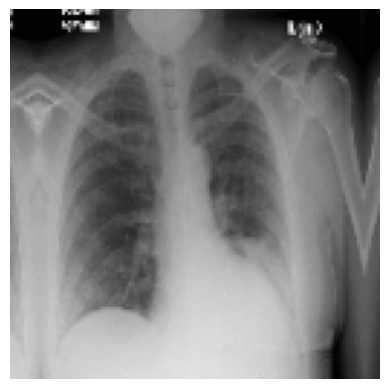

In [21]:
print(train_Y[0])
display_image_from_array(train_X[0])

# Model from Scratch

In [22]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [23]:
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [checkpoint, early]

In [24]:
feature_layers = [
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
]
classification_layers = [

  
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(all_labels), activation='sigmoid')
]
ScratchModel = Sequential(feature_layers + classification_layers)

In [25]:
ScratchModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [26]:
optimizers_list = [('adagrad',optimizers.Adagrad()) ]

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)

callbacks_list = [early, ModelCheckpoint( filepath=weight_path, monitor='val_loss', mode='min', save_best_only=True )]

Epoch 1/10
1000/1000 [==============================] - 121s 119ms/step - loss: 0.6499 - binary_accuracy: 0.7825 - mae: 0.4764 - val_loss: 0.5422 - val_binary_accuracy: 0.8690 - val_mae: 0.4130
Epoch 2/10


C:\Users\paulo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1000/1000 [==============================] - 122s 122ms/step - loss: 0.4034 - binary_accuracy: 0.8576 - mae: 0.2640 - val_loss: 0.3447 - val_binary_accuracy: 0.8687 - val_mae: 0.2111
Epoch 3/10
1000/1000 [==============================] - 121s 121ms/step - loss: 0.3706 - binary_accuracy: 0.8625 - mae: 0.2232 - val_loss: 0.3442 - val_binary_accuracy: 0.8687 - val_mae: 0.2106
Epoch 4/10
1000/1000 [==============================] - 124s 124ms/step - loss: 0.3662 - binary_accuracy: 0.8635 - mae: 0.2202 - val_loss: 0.3448 - val_binary_accuracy: 0.8687 - val_mae: 0.2147
Epoch 5/10
1000/1000 [==============================] - 124s 124ms/step - loss: 0.3615 - binary_accuracy: 0.8655 - mae: 0.2175 - val_loss: 0.3448 - val_binary_accuracy: 0.8687 - val_mae: 0.2151
Epoch 6/10
1000/1000 [==============================] - 123s 123ms/step - loss: 0.3613 - binary_accuracy: 0.8651 - mae: 0.2178 - val_loss: 0.3440 - val_binary_accuracy: 0.8687 - val_mae: 0.2108
Epoch 7/10
1000/1000 [===================

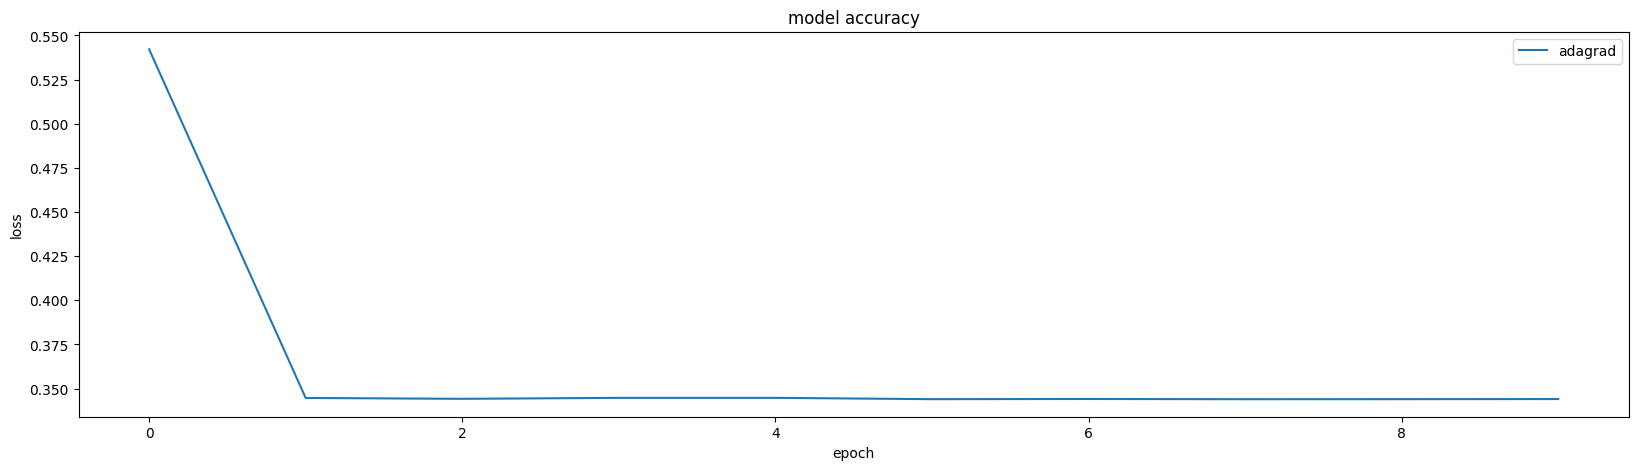

<Figure size 640x480 with 0 Axes>

In [27]:
plt.figure(figsize=(20,5))
for optimizer in optimizers_list:
    ScratchModel.compile(optimizer = optimizer[1], loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
    ScratchHistory = ScratchModel.fit(train_X, train_Y,
                        steps_per_epoch=1000,
                        epochs=10,
                        verbose=1,
                        callbacks = callbacks_list,
                        validation_data=(test_X, test_Y))
    
    plt.plot(ScratchHistory.history['val_loss'])
    
plt.legend([x[0] for x in optimizers_list], loc='upper right')
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('optimizer_selection.png', bbox_inches='tight')

In [28]:
# Save model architecture to JSON
model_json = ScratchModel.to_json()
with open("ScratchModel.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights to HDF5
ScratchModel.save_weights("ScratchModelWeights.h5")

# Save training history to JSON
history_dict = ScratchHistory.history
with open('ScratchHistory.json', 'w') as json_file:
    json.dump(history_dict, json_file)

# Pre-Trained Model using Mobilenetv2

In [29]:
base_mobilenet_model = MobileNet(input_shape =  [128, 128, 1], 
                                 include_top = False, weights = None)
PreTrainedModel = Sequential()
PreTrainedModel.add(base_mobilenet_model)
PreTrainedModel.add(GlobalAveragePooling2D())
PreTrainedModel.add(Dropout(0.5))
PreTrainedModel.add(Dense(512))
PreTrainedModel.add(Dropout(0.5))
PreTrainedModel.add(Dense(len(all_labels), activation = 'sigmoid'))
PreTrainedModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228288   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 13)               

In [30]:
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [checkpoint, early]

In [31]:
optimizers_list = [('adagrad',optimizers.Adagrad())]

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)

callbacks_list = [early, ModelCheckpoint( filepath=weight_path, monitor='val_loss', mode='min', save_best_only=True )]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228288   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 13)               

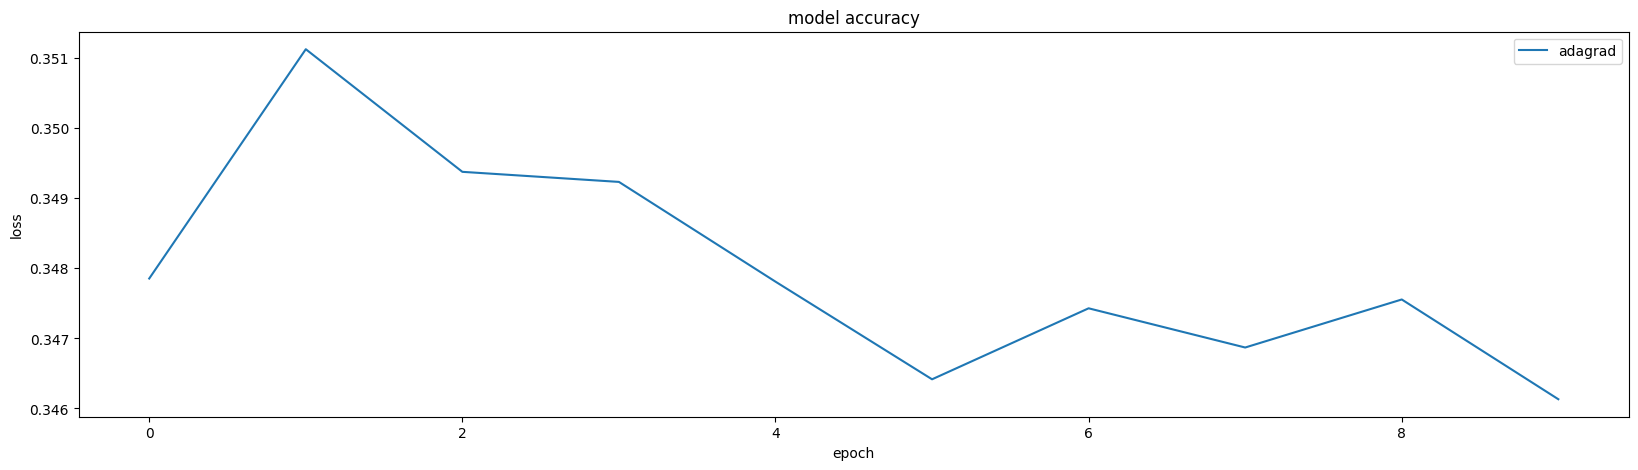

<Figure size 640x480 with 0 Axes>

In [32]:
# original epoch 50 , 1 for testing
plt.figure(figsize=(20,5))
for optimizer in optimizers_list:
    PreTrainedModel.compile(optimizer = optimizer[1], loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
    PreTrainedModel.summary()
    PreTrainedHistory = PreTrainedModel.fit(train_X, train_Y,
                        steps_per_epoch=1000,
                        epochs=10,
                        verbose=1,
                        callbacks = callbacks_list,
                        validation_data=(test_X, test_Y))
    
    plt.plot(PreTrainedHistory.history['val_loss'])
    
plt.legend([x[0] for x in optimizers_list], loc='upper right')
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('optimizer_selection.png', bbox_inches='tight')

In [33]:
# Save model architecture to JSON
model_json = PreTrainedModel.to_json()
with open("PreTrainedModel.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights to HDF5
PreTrainedModel.save_weights("PreTrainedModelWeights.h5")

# Save training history to JSON
history_dict = PreTrainedHistory.history
with open('PreTrainedHistory.json', 'w') as json_file:
    json.dump(history_dict, json_file)

# Metrics

In [47]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)
    plt.xlabel("Probability")
    plt.ylabel("Loss")

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["binary_accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_binary_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

def evaluate_multilabel_classification_stats(y_true, probas, threshold=0.2):
    # Convert probabilities to binary predictions based on the threshold
    y_pred_binary = (probas > threshold).astype(int)

    # Compute Hamming Loss
    hamming_loss_value = hamming_loss(y_true, y_pred_binary)

    # Compute Precision, Recall, and F1-score

    precision = precision_score(y_true, y_pred_binary, average='samples')
    recall = recall_score(y_true, y_pred_binary, average='samples')
    f1 = f1_score(y_true, y_pred_binary, average='samples')

    # Compute Subset Accuracy
    subset_accuracy = accuracy_score(y_true, y_pred_binary)

    print("Hamming Loss: {:.4f}".format(hamming_loss_value))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-score: {:.4f}".format(f1))
    print("Subset Accuracy: {:.4f}".format(subset_accuracy))

def evaluate_multilabel_classification(y_true, probas, model_name, threshold=0.2):
    # Convert probabilities to binary predictions based on the threshold
    y_pred_binary = (probas > threshold).astype(int)

    # Calculate multilabel confusion matrix
    multilabel_cm = multilabel_confusion_matrix(y_true, y_pred_binary)

    # Print confusion matrix for each class
    for i, cm in enumerate(multilabel_cm):
        print(f"Confusion Matrix for Class {i}:")
        print(cm)
        print()

    # Calculate classification report for each class
    class_report = classification_report(y_true, y_pred_binary, zero_division=1)
    print(f"{model_name} Classification Report:")
    print(class_report)

def plot_multilabel_roc(y_test, probas, model_name, threshold=0.2):

    y_pred_binary = (probas > threshold).astype(int)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for i in range(y_test.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_binary[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(y_test.shape[1]):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

    # Plot random guess line
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # Plotting settings
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC) for multi-label classification')
    plt.legend(loc='lower right')
    plt.show()

def display_comparison_random(y_true, probas, threshold=0.5, num_entries=5):
    print("Entry\tTrue Label\t|\tPredicted Label (Threshold = {:.2f})".format(threshold))
    print("-" * 50)
    
    # Get a random subset of indices
    random_indices = random.sample(range(len(y_true)), min(num_entries, len(y_true)))
    
    for i in random_indices:
        true_label = ", ".join([str(label) for label, value in enumerate(y_true[i]) if value == 1])
        pred_label = ", ".join([str(label) for label, value in enumerate(probas[i]) if value > threshold])
        print(f"{i}\t{true_label}\t|\t{pred_label}")
        print("-" * 50)

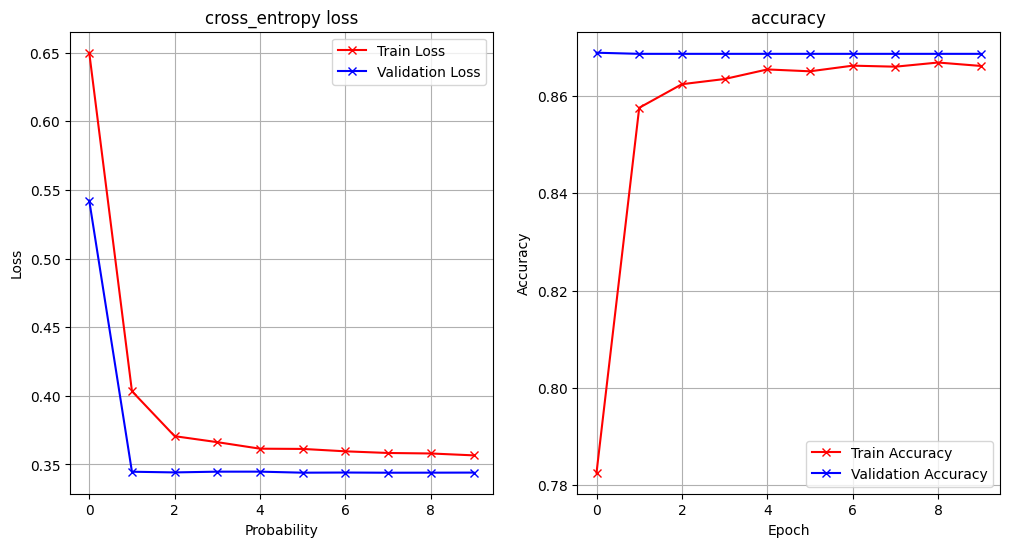

In [35]:
plot_loss_accuracy(ScratchHistory)

In [36]:
print_class_table(label_map)

| Class # | Class Name          |
|---------|---------------------|
|   0     | Atelectasis          |
|   1     | Cardiomegaly         |
|   2     | Consolidation        |
|   3     | Edema                |
|   4     | Effusion             |
|   5     | Emphysema            |
|   6     | Fibrosis             |
|   7     | Infiltration         |
|   8     | Mass                 |
|   9     | Nodule               |
|   10     | Pleural_Thickening   |
|   11     | Pneumonia            |
|   12     | Pneumothorax         |


In [37]:
ScratchProb = ScratchModel.predict(test_X)

63/63 [==============================] - 7s 103ms/step


In [38]:
evaluate_multilabel_classification_stats(test_Y, ScratchProb)

Hamming Loss: 0.2188
Precision: 0.3107
Recall: 0.5619
F1-score: 0.3794
Subset Accuracy: 0.0160


In [39]:
evaluate_multilabel_classification(test_Y, ScratchProb, 'ScratchModel')

Confusion Matrix for Class 0:
[[   0 1526]
 [   1  473]]

Confusion Matrix for Class 1:
[[1885    0]
 [ 115    0]]

Confusion Matrix for Class 2:
[[1789    0]
 [ 211    0]]

Confusion Matrix for Class 3:
[[1909    0]
 [  91    0]]

Confusion Matrix for Class 4:
[[   0 1423]
 [   0  577]]

Confusion Matrix for Class 5:
[[1897    0]
 [ 103    0]]

Confusion Matrix for Class 6:
[[1932    0]
 [  68    0]]

Confusion Matrix for Class 7:
[[   0 1186]
 [   0  814]]

Confusion Matrix for Class 8:
[[1754    0]
 [ 246    0]]

Confusion Matrix for Class 9:
[[1727    5]
 [ 267    1]]

Confusion Matrix for Class 10:
[[1838    0]
 [ 162    0]]

Confusion Matrix for Class 11:
[[1934    0]
 [  66    0]]

Confusion Matrix for Class 12:
[[1782    0]
 [ 218    0]]

ScratchModel Classification Report:
              precision    recall  f1-score   support

           0       0.24      1.00      0.38       474
           1       1.00      0.00      0.00       115
           2       1.00      0.00      0.00 

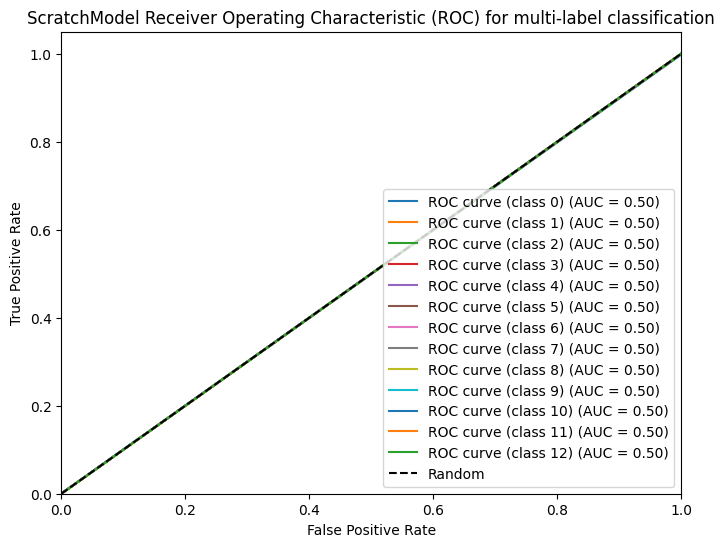

In [40]:
plot_multilabel_roc(test_Y, ScratchProb, 'ScratchModel')

In [41]:
display_comparison(test_Y, ScratchProb, 0.2 )

Entry	True Label	|	Predicted Label (Threshold = 0.20)
--------------------------------------------------
0	7	|	0, 4, 7
--------------------------------------------------
1	2, 4, 8	|	0, 4, 7
--------------------------------------------------
2	7	|	0, 4, 7
--------------------------------------------------
3	7	|	0, 4, 7
--------------------------------------------------
4	0	|	0, 4, 7
--------------------------------------------------
5	0	|	0, 4, 7
--------------------------------------------------
6	7	|	0, 4, 7
--------------------------------------------------
7	12	|	0, 4, 7
--------------------------------------------------
8	7	|	0, 4, 7
--------------------------------------------------
9	0, 2, 3, 4, 7	|	0, 4, 7
--------------------------------------------------
10	10	|	0, 4, 7
--------------------------------------------------
11	3, 7	|	0, 4, 7
--------------------------------------------------
12	10	|	0, 4, 7
--------------------------------------------------
13	10	|	0, 4, 7
-------

In [42]:
test_Y[4]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [43]:
ScratchProb[4]

array([0.24411939, 0.04867806, 0.09392306, 0.04440542, 0.2933846 ,
       0.04958512, 0.03336981, 0.39957646, 0.11861061, 0.13335468,
       0.06421366, 0.03285887, 0.10578334], dtype=float32)

| Class # | Class Name          |
|---------|---------------------|
|   0     | Atelectasis          |
|   1     | Cardiomegaly         |
|   2     | Consolidation        |
|   3     | Edema                |
|   4     | Effusion             |
|   5     | Emphysema            |
|   6     | Fibrosis             |
|   7     | Infiltration         |
|   8     | Mass                 |
|   9     | Nodule               |
|   10     | Pleural_Thickening   |
|   11     | Pneumonia            |
|   12     | Pneumothorax         |
63/63 [==============================] - 14s 200ms/step
Hamming Loss: 0.1909
Precision: 0.3471
Recall: 0.4910
F1-score: 0.3742
Subset Accuracy: 0.0505
Confusion Matrix for Class 0:
[[631 895]
 [147 327]]

Confusion Matrix for Class 1:
[[1885    0]
 [ 115    0]]

Confusion Matrix for Class 2:
[[1789    0]
 [ 211    0]]

Confusion Matrix for Class 3:
[[1909    0]
 [  91    0]]

Confusion Matrix for Class 4:
[[ 334 1089]
 [  95  482]]

Confusion Matrix for Class 5:
[[1897 

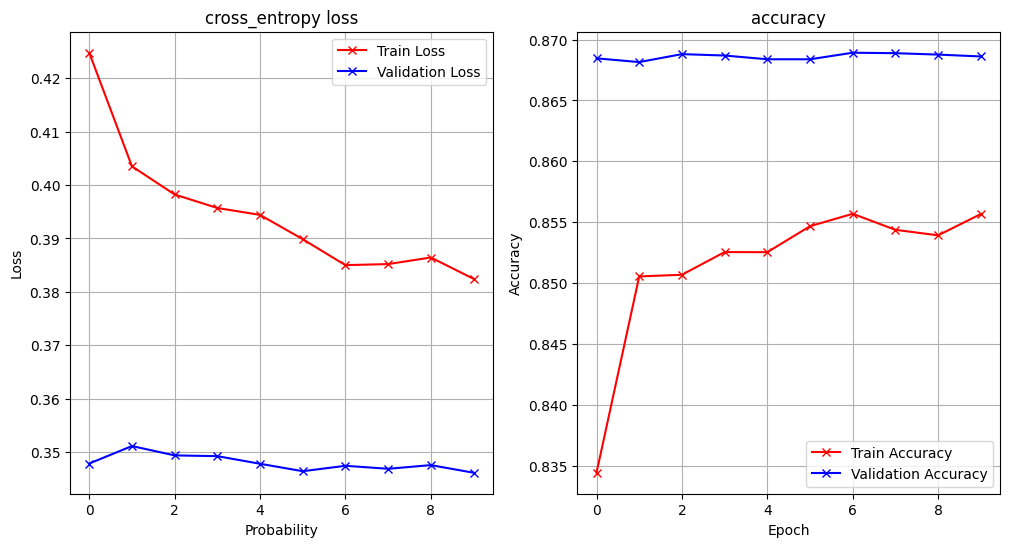

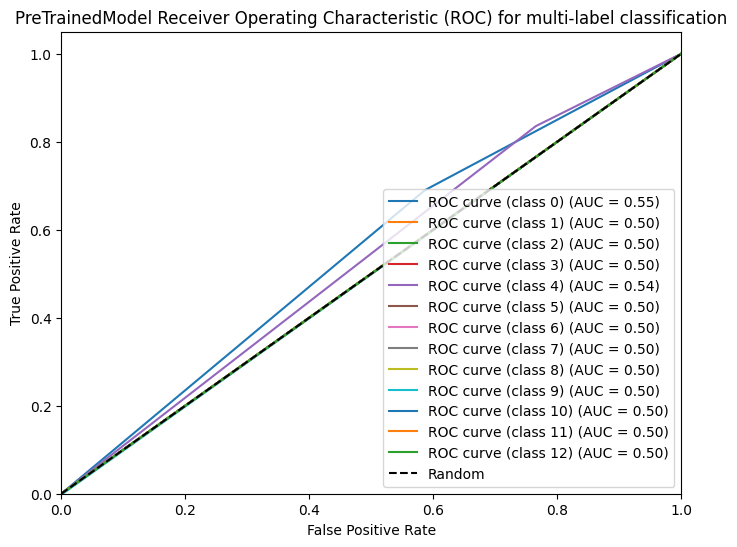

In [44]:
# for PreTrainedModel
plot_loss_accuracy(PreTrainedHistory)
print_class_table(label_map)
PreTrainedProb = PreTrainedModel.predict(test_X)
evaluate_multilabel_classification_stats(test_Y, PreTrainedProb)
evaluate_multilabel_classification(test_Y, PreTrainedProb, 'PreTrainedModel')
plot_multilabel_roc(test_Y, PreTrainedProb, 'PreTrainedModel')

In [57]:
display_comparison_random(test_Y, ScratchProb, 0.2 )

Entry	True Label	|	Predicted Label (Threshold = 0.20)
--------------------------------------------------
369	0, 4	|	0, 4, 7
--------------------------------------------------
1349	0	|	0, 4, 7
--------------------------------------------------
266	0	|	0, 4, 7
--------------------------------------------------
1227	7	|	0, 4, 7
--------------------------------------------------
1101	6, 8	|	0, 4, 7
--------------------------------------------------


In [58]:
display_comparison_random(test_Y, PreTrainedProb, 0.2 )

Entry	True Label	|	Predicted Label (Threshold = 0.20)
--------------------------------------------------
729	7	|	0, 4, 7
--------------------------------------------------
608	0, 2, 4	|	0, 4, 7
--------------------------------------------------
1801	4	|	0, 4, 7
--------------------------------------------------
362	7	|	0, 4, 7
--------------------------------------------------
48	7	|	4, 7
--------------------------------------------------


# Analysis

The goal is to create a model that predicts certain medical conditions using X-ray images. It is going to work as a multi-label model outputting zero to max medical conditions per image hence I used relu and sigmoid activation function. We have created 2 models the first is "Scratch" based on it's name I personally choose the feature layers, classification layers, and all other parameters for the model. While the second is "PreTrained" I used mobilenetv2 as a base model while I also didn't include it's default weights because this is an X-ray image also having just 1 channel for color. It is not your typical types of images the imagenet weights was trained on. Here are the main configurations for each model 

(Scratch, Total params: 312973, Trainable params: 312973, Non-trainable params: 0)

(PreTrained, Total params: 3759757,Trainable params: 3737869, Non-trainable params: 21888). 

Both are trained on 8000 images and 2000 images for the testing. Both also have 10 epoch with 1000 steps per epoch. 
Here are the final result of each model

(Scratch, 120 seconds per epoch, loss: 0.3566 - binary_accuracy: 0.8662 - mae: 0.2143 - val_loss: 0.3441 - val_binary_accuracy: 0.8687 - val_mae: 0.2125)

(PreTrained, 320 seconds per epoch, loss: 0.3824 - binary_accuracy: 0.8557 - mae: 0.2057 - val_loss: 0.3461 - val_binary_accuracy: 0.8686 - val_mae: 0.1902).

In the cross-entropy and accuracy metrics it suggest that even if we increase the epoch it would not improve it's performance. While other metrics such as confusion matrix, classification report, and ROC curve and ROC-AUC suggest the models is just guessing.

# Conclusion

Based on my results I have come to a conclusion that the model I have created are useless in the goal of multilabeling X-ray images on what medical conditions are present. I it may suggest that the data is not apppropriate for this, or this is not yet in the capabilities of CNN models.The Scratch model reached binary_accuracy: 0.8662 and val_binary_accuracy: 0.8687 while the PreTrained model reached binary_accuracy: 0.8557 and val_binary_accuracy: 0.8686. Both are very close to each other.och.